## Analysis of Color Scheme on User Behavior
### By Eric Smith

This Notebook serves as a scratchpad to process and anaylze data exported from [SMUTechSurvey.com](http://smutechsurvey.com)

For complete source code and a list of questions asked, please see the root directory of this repo.

Some of the data has been removed to protect the privacy of users.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from collections import OrderedDict
from textwrap import wrap

In [2]:
df = pd.read_json('./Data/db_export.csv', 
                  encoding='ISO-8859-1')
df = df.drop(['email'], axis=1) 
df[df.columns[-3:]].describe()

,computerButtonClicked,themeChosen,timeToComplete
count,58.000000,58.000000,58.000000
mean,0.051724,2.672414,108.829293
std,0.291542,1.114308,60.477376
min,0.000000,1.000000,51.131000
25%,0.000000,2.000000,75.006750
50%,0.000000,3.000000,86.352000
75%,0.000000,4.000000,120.200250
max,2.000000,4.000000,412.624000


### First, we'll need to extract the questions and their choices from the webpage


In [3]:
# open the webpage to parse for questions
with open ('./../AB-Testing-Form/templates/index.phtml') as fp:
    soup = BeautifulSoup(fp, 'html.parser')

In [4]:
survey_questions = {}  # question : [choices]

In [5]:
# for each page in the form
pages = soup.find_all('div', class_='page')
for p in range(len(pages)):
    
    if p > 0:  # ignore the first page
        questions = pages[p].find_all('div', class_='row section')
        
        for q in questions:
            # strip the number from the question
            question_title = q.find('h5').contents[1]
            
            # option tags surrounding the choices
            options = q.find('div', class_="input-field col s12 m8"
                            ).find('select').find_all('option')
            
            choices = []
            
            # keep track of those choices that aren't disabled
            for o in options:
                if 'disabled' not in str(o):
                    choices.append(o.contents[0])

            survey_questions[question_title] = choices 

In [6]:
# list of dictionaries containing responses and their occurrences
responses = []

df_questions = df

cols_to_remove = 4

# remove those instances that weren't completed
if 'dropout' in df.columns:
    df_questions = df[df.dropout != 'true']
    cols_to_remove += 2
    
# remove non-questions from the data
df_questions = df_questions.iloc[:, :-cols_to_remove]  

for column in df_questions:
    col = df_questions[column]
    
    # questions with one option
    if col.dtype == "int64":
        responses.append(dict(sorted(Counter(col).items())))
    else:  # questions with multiple values
        # join the responses
        combined_responses = [int(inner) for outer in col 
                              for inner in outer]
        responses.append(dict(sorted(Counter(combined_responses).items())))

### Then, we'll tabulate the results of each question and look at the distributions of the responses.

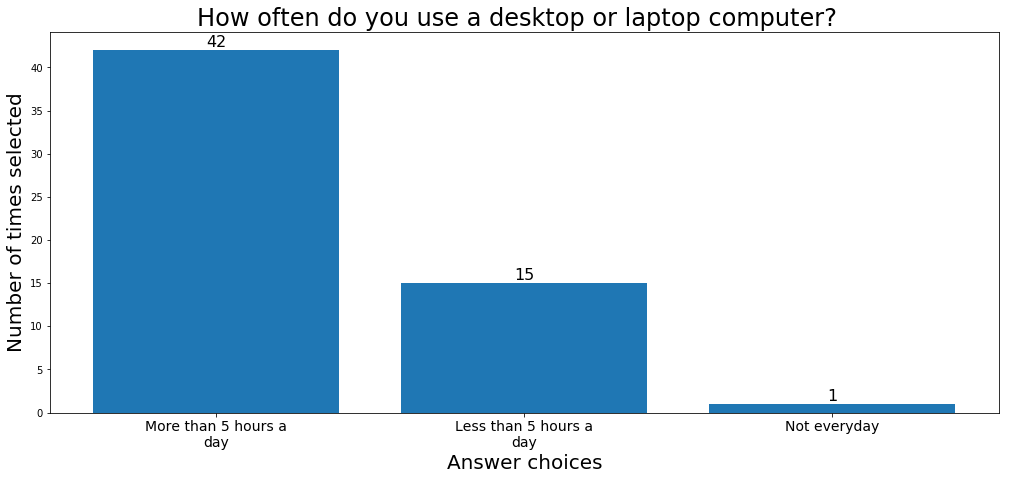

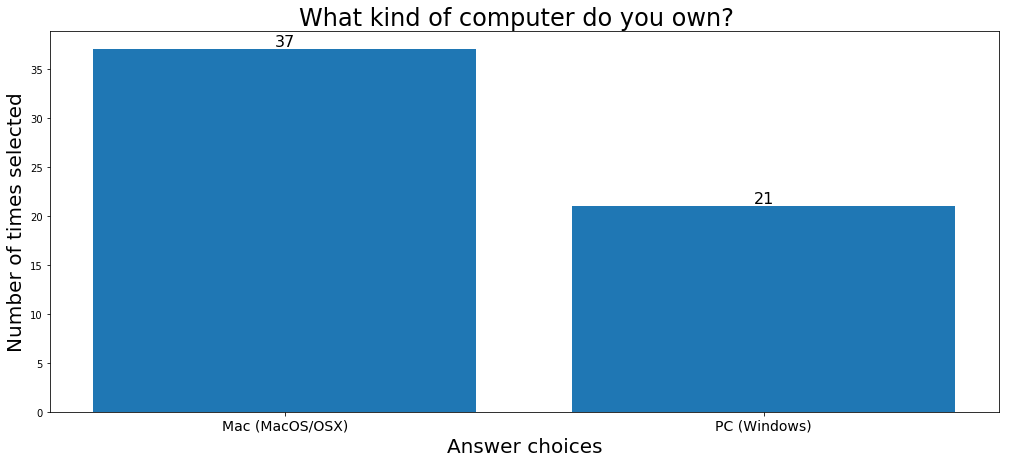

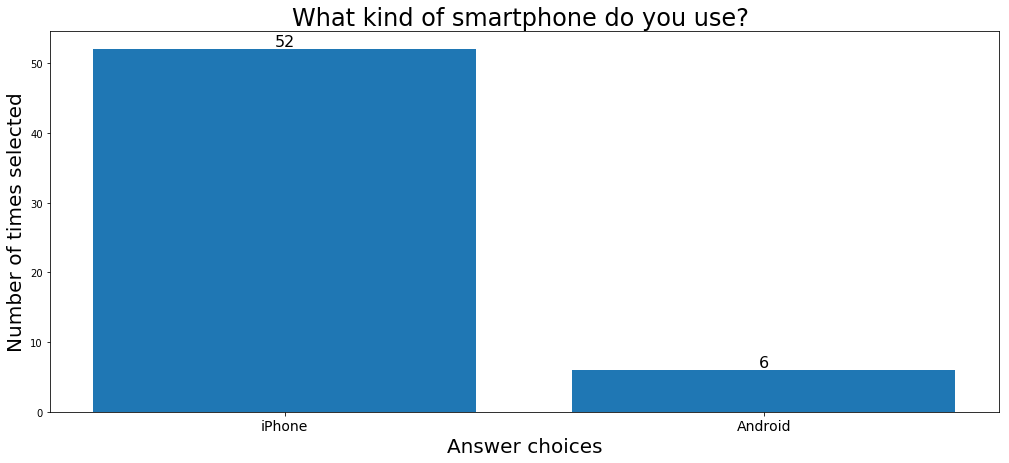

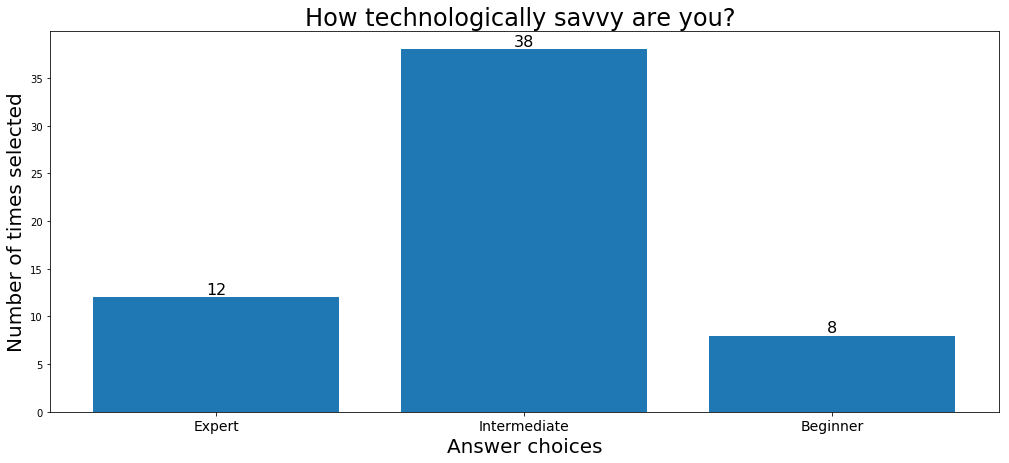

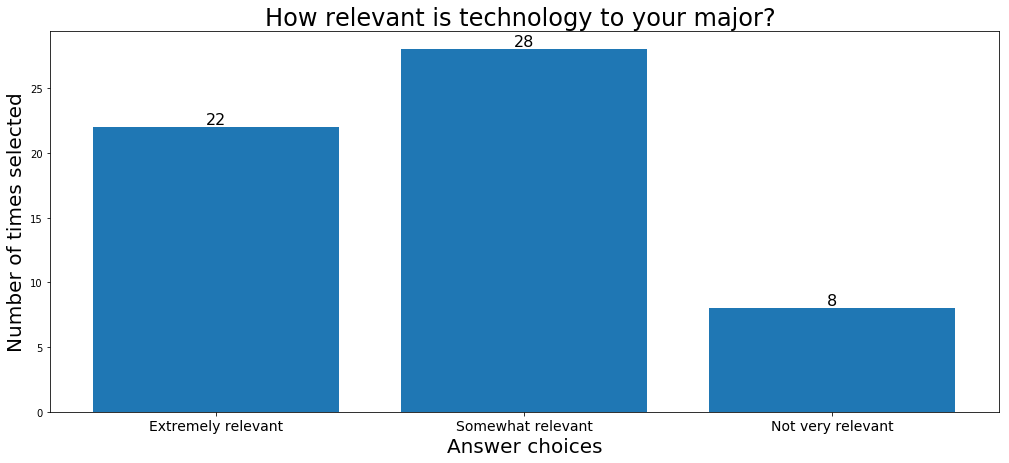

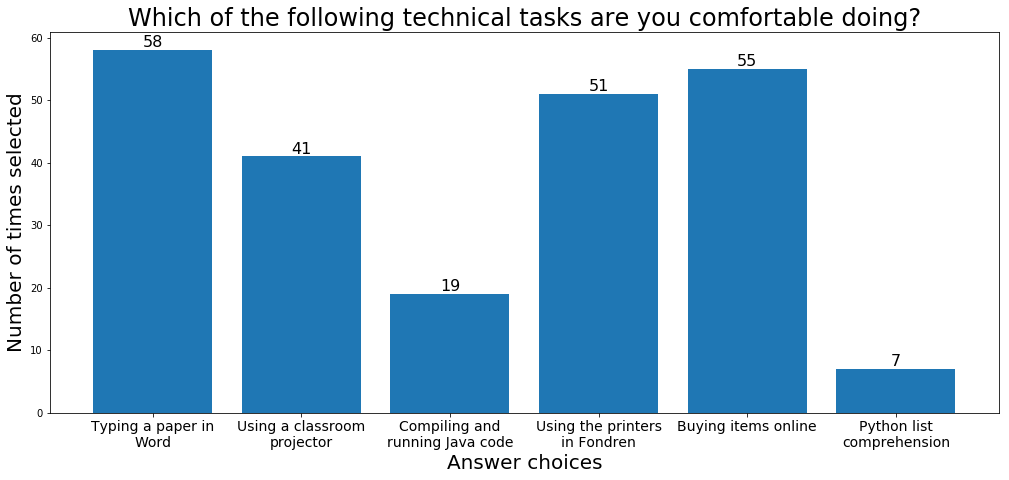

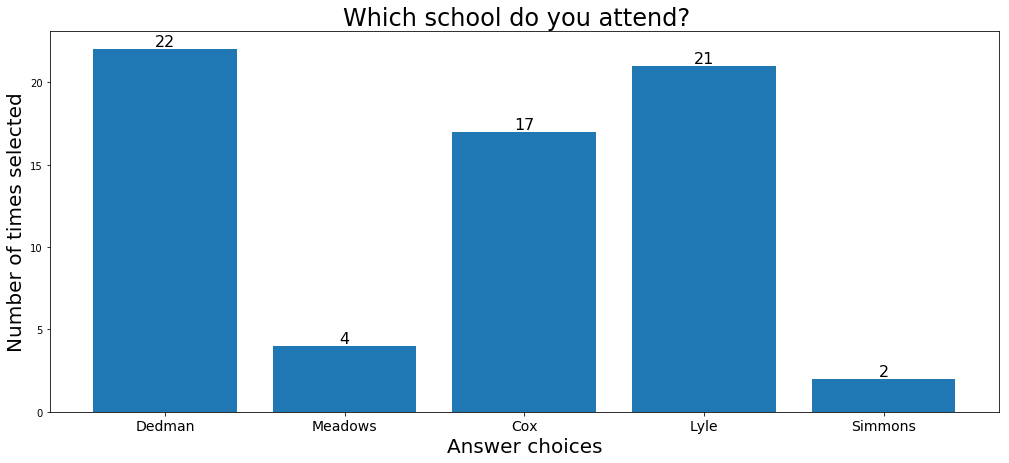

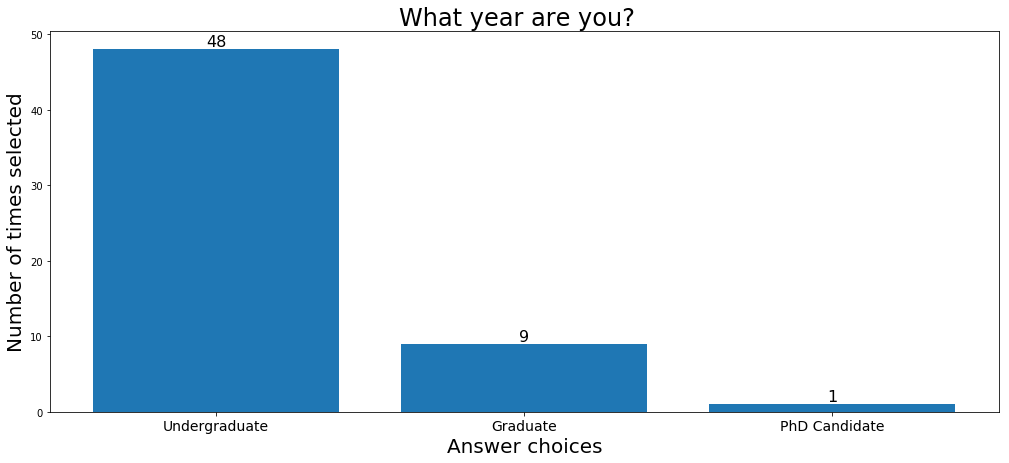

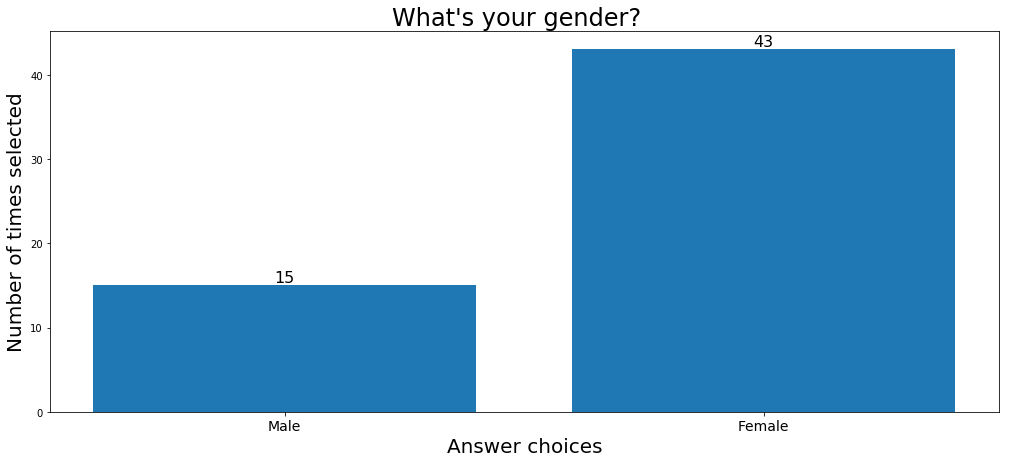

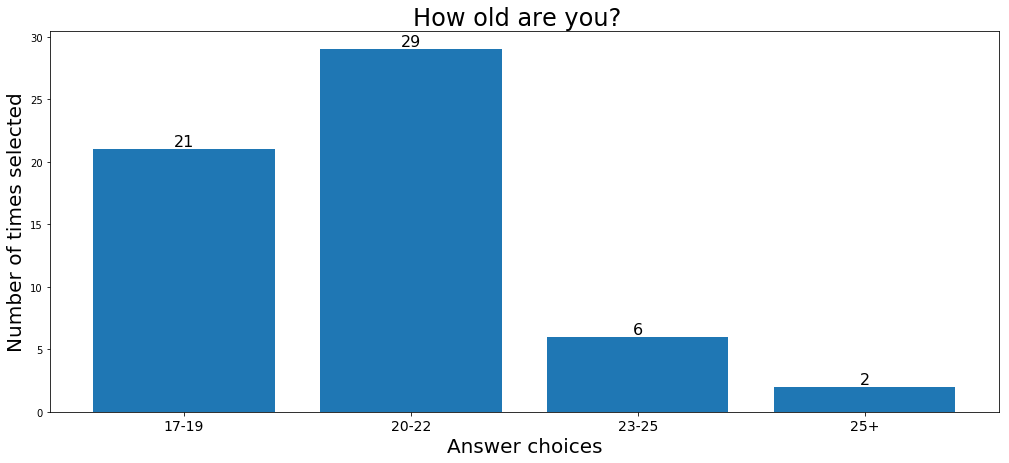

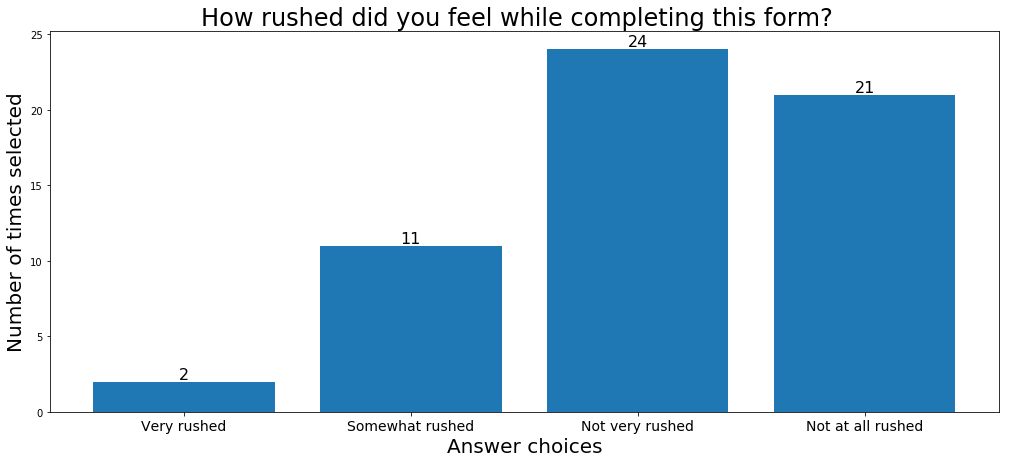

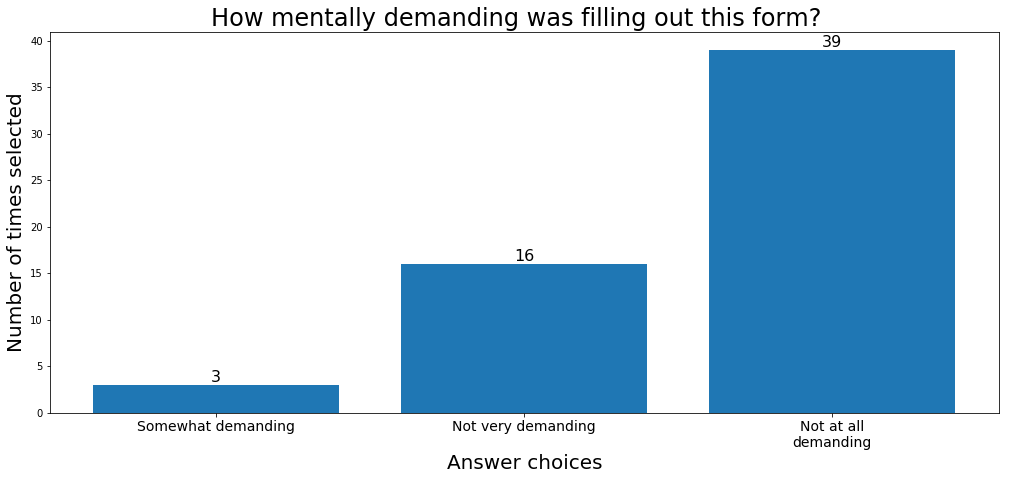

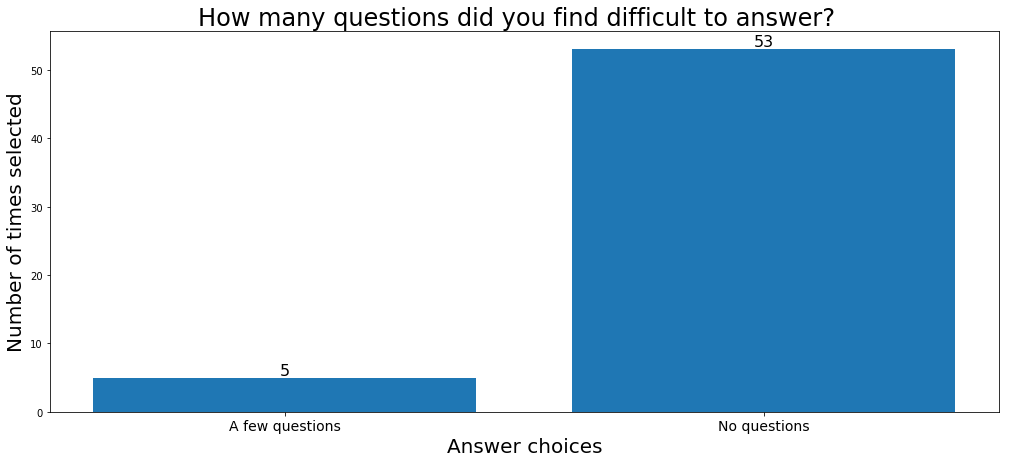

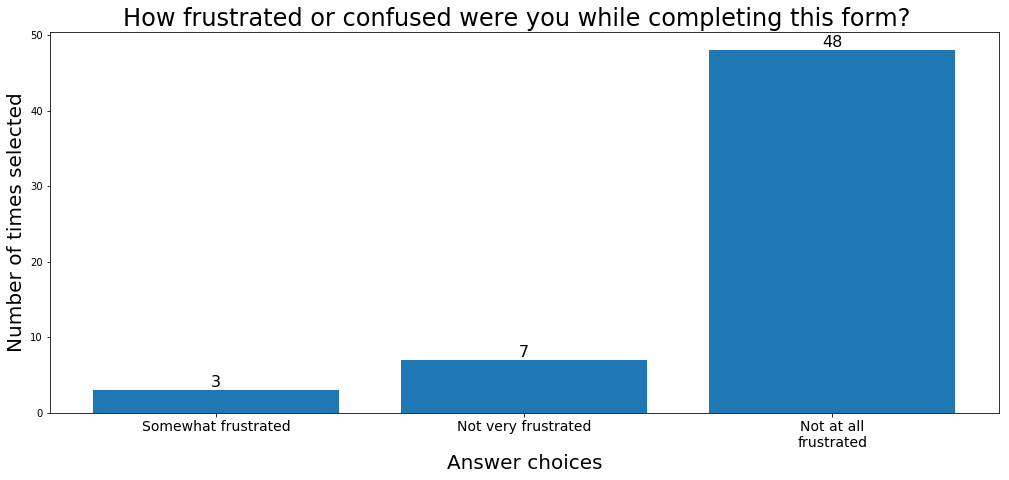

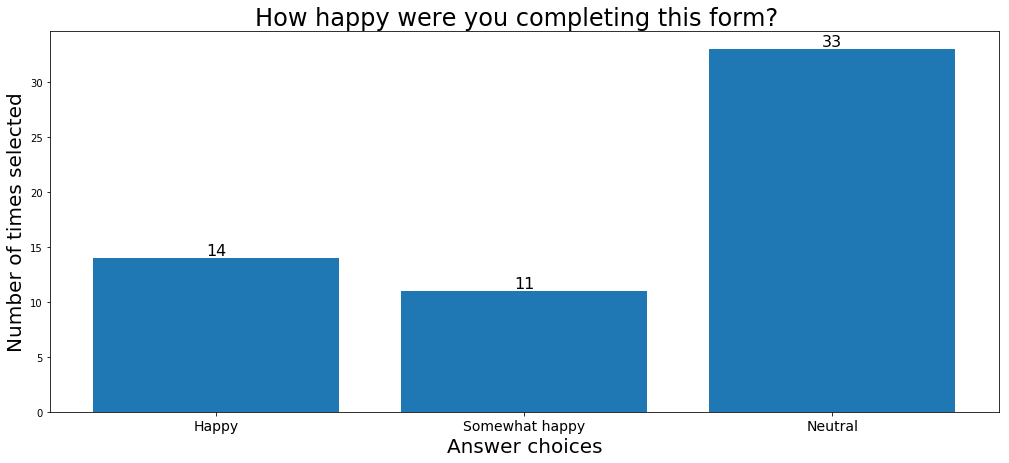

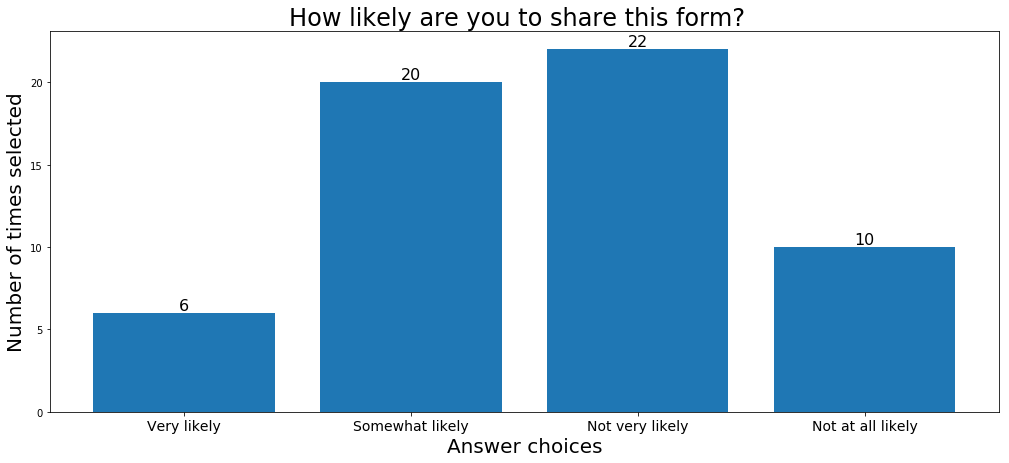

In [23]:
for r in range(len(responses)):
    # total numbers of times options were chosen
    totalled_answers = responses[r].values()
    
    # text of questions and answers
    title = list(survey_questions.keys())[r]
    choices = list(survey_questions.values())[r]
    
    selected_choices = []
    
    # remove the choices that were never selected
    for c in range(1, len(choices)+1):
        if c in sorted(responses[r].keys()):
            selected_choices.append(choices[c-1])
            
    # wrap words if too long
    selected_choices = [ '\n'.join(wrap(sc, 19)) for sc in selected_choices ]
            
    # logic for building bar chart
    y_pos = np.arange(len(selected_choices))
    plt.figure(figsize=(17,7))
    bars = plt.bar(y_pos, totalled_answers, align='center')
    plt.xticks(y_pos, selected_choices, size=14)
    plt.xlabel('Answer choices', size=20)
    plt.ylabel('Number of times selected', size=20)
    plt.title(title, size=24)
    
    # add labels over bars
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, 
                 '%d' % int(height), ha='center', va='bottom', size=16)

    plt.savefig('./Images/' + 'question' + str(r+1) + '.png');    
    plt.show()


# clean the plot object when done
plt.clf()
plt.cla()
plt.close()

### Let's then see how the site randomly distributed the different themes.

In [32]:
df_colors = df.groupby("themeChosen").size()
df_colors
themes = ["Theme " + str(i) for i in range(1,5)]

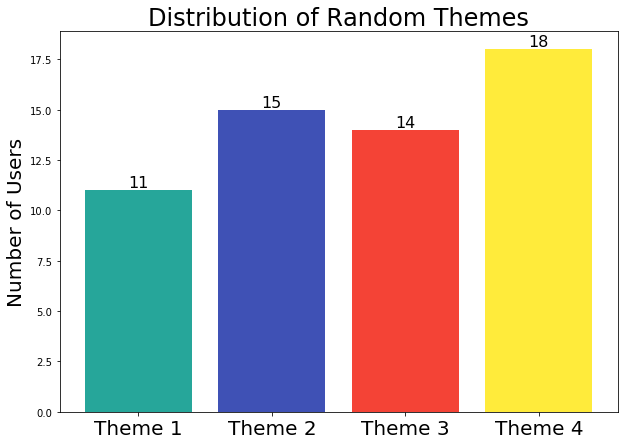

In [34]:
y_pos = np.arange(len(df_colors))
plt.figure(figsize=(10,7))
bars = plt.bar(y_pos, df_colors, align='center', color=colors)
plt.xticks(y_pos, themes, size=20)

plt.ylabel('Number of Users', size=20)
plt.title("Distribution of Random Themes", size=24)

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, 
             '%d' % int(height), ha='center', va='bottom', size=16)

plt.savefig('./Images/theme_distribution.png');    
plt.show()

### Then, we'll take a look at how responses differed by color scheme.

In [46]:
def create_stacked_barchart(dataset, title, choices, colors, img_count):
    names = sorted(dataset[0].keys())
    values = np.array([[data[name] for name in order] for data,order in zip(dataset, data_orders)])
    lefts = np.insert(np.cumsum(values, axis=1),0,0, axis=1)[:, :-1]
    orders = np.array(data_orders)
    bottoms = np.arange(len(data_orders))
    
    choices = [ '\n'.join(wrap(sc, 19)) for sc in choices ]
    
    plt.figure(figsize=(15,10))

    for name, color in zip(names, colors):
        idx = np.where(orders == name)
        value = values[idx]
        left = lefts[idx]
        bars = plt.bar(left=left, height=0.8, width=value, bottom=bottoms, 
                color=color, orientation="horizontal", label=name)
        
    plt.yticks(bottoms, choices, size=20)
    plt.xlabel('Number of times selected', size=20)
    plt.title(title, size=28)


    plt.legend(['Theme 1', 'Theme 2', 'Theme 3', 'Theme 4'], 
               loc="best", bbox_to_anchor=(1.0, 1.00), fontsize=20)
    plt.subplots_adjust(right=0.85)
    
    
    plt.savefig('./Images/' + 'color_question' + str(img_count+1) + '.png', bbox_inches = 'tight');  
    plt.show()

    # clean the plot object when done
    plt.clf()
    plt.cla()
    plt.close()

    """
    order the data in a row of dictionaries such that:
        row = answer choice
        key = color scheme
        value = number of people w that color who made that choice
    """
colors = ["#26a69a","#3f51b5","#f44336","#ffeb3b"]  # primary colors of each theme
dataset = []

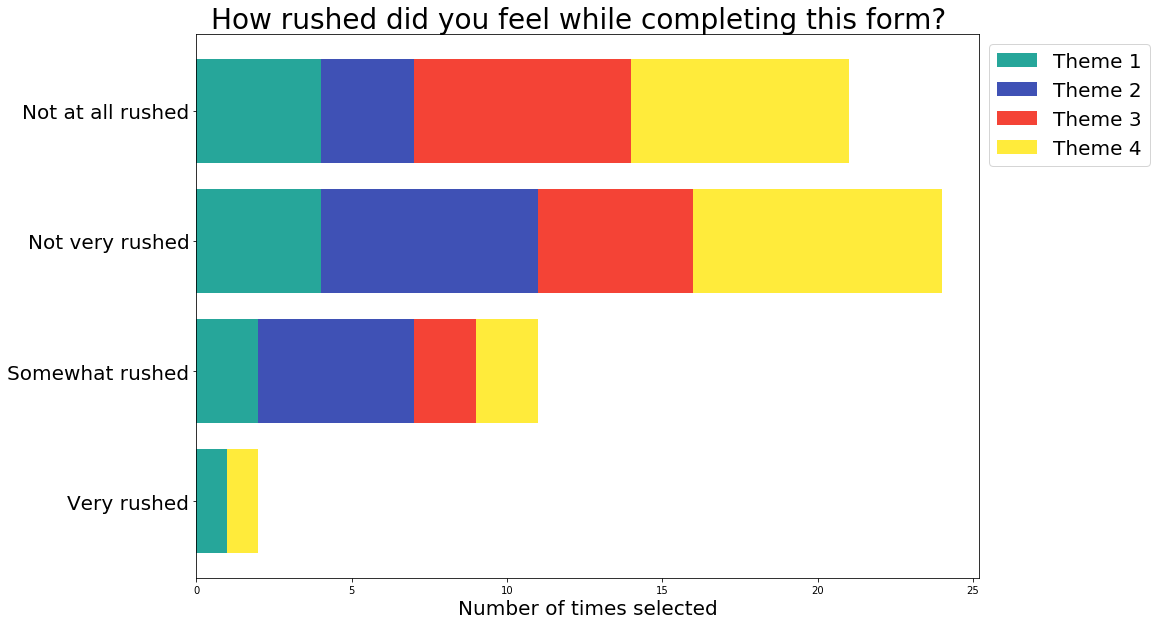

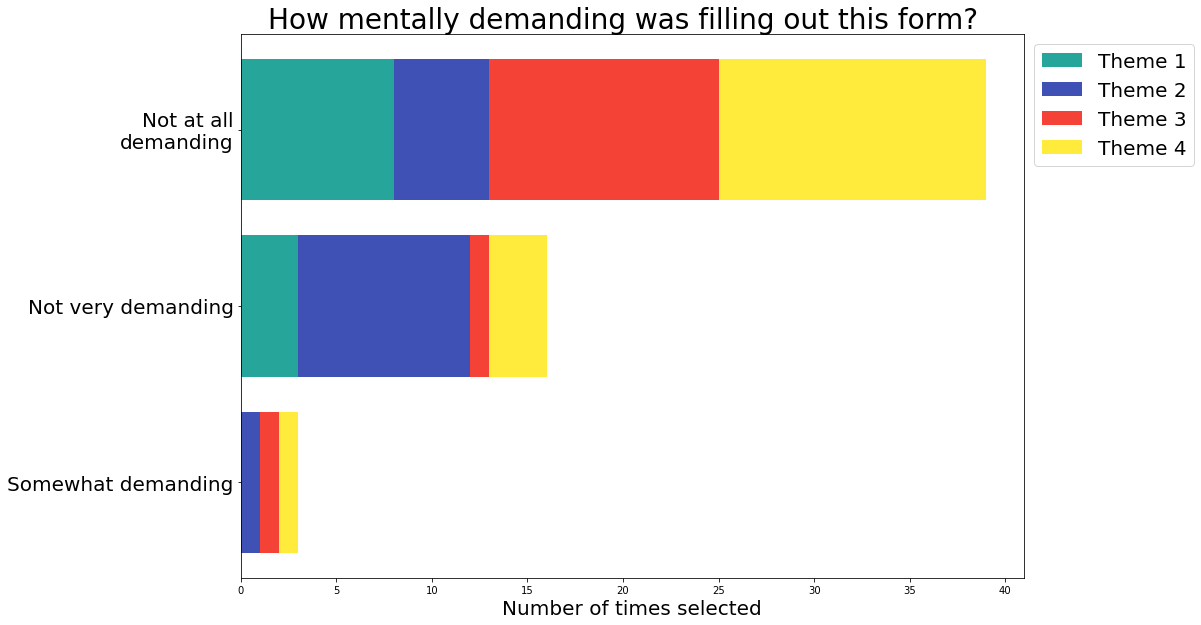

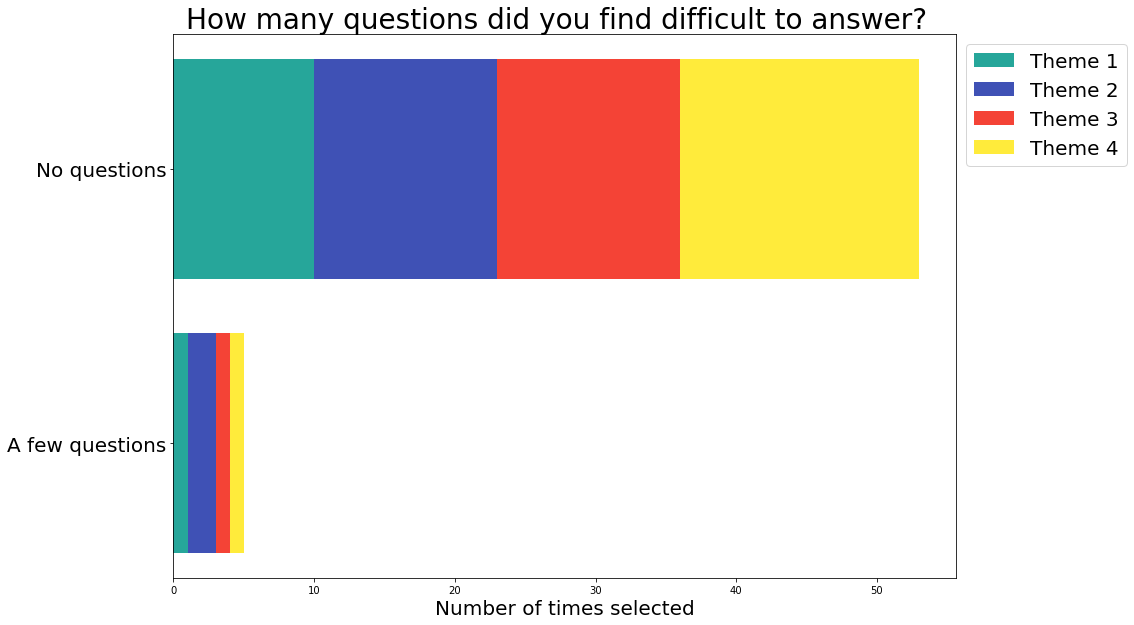

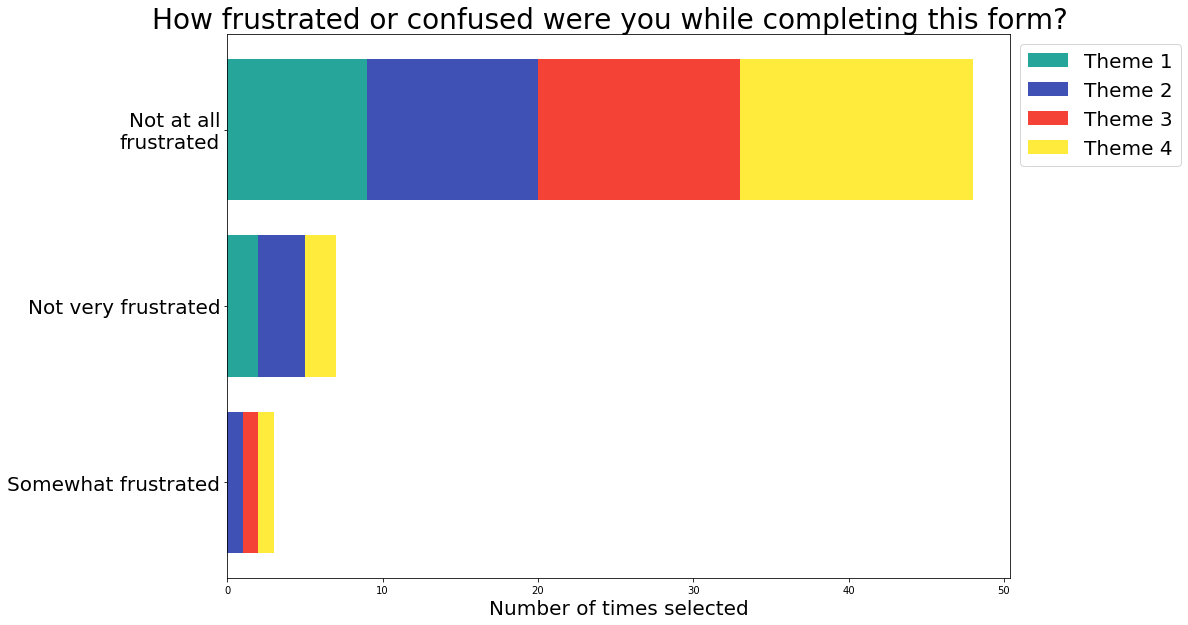

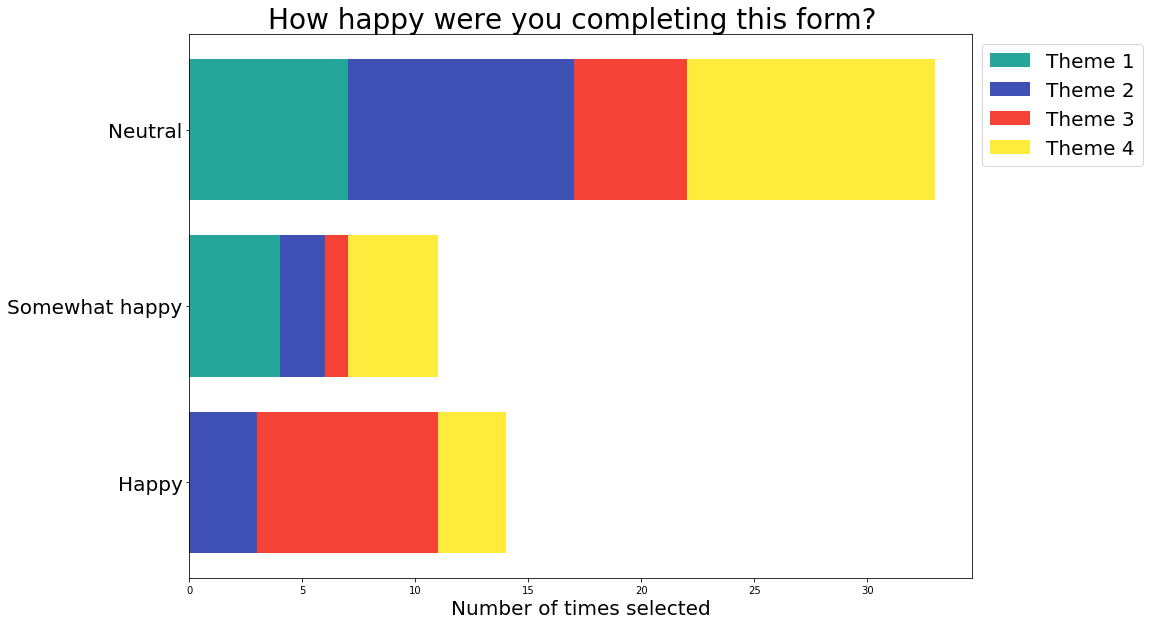

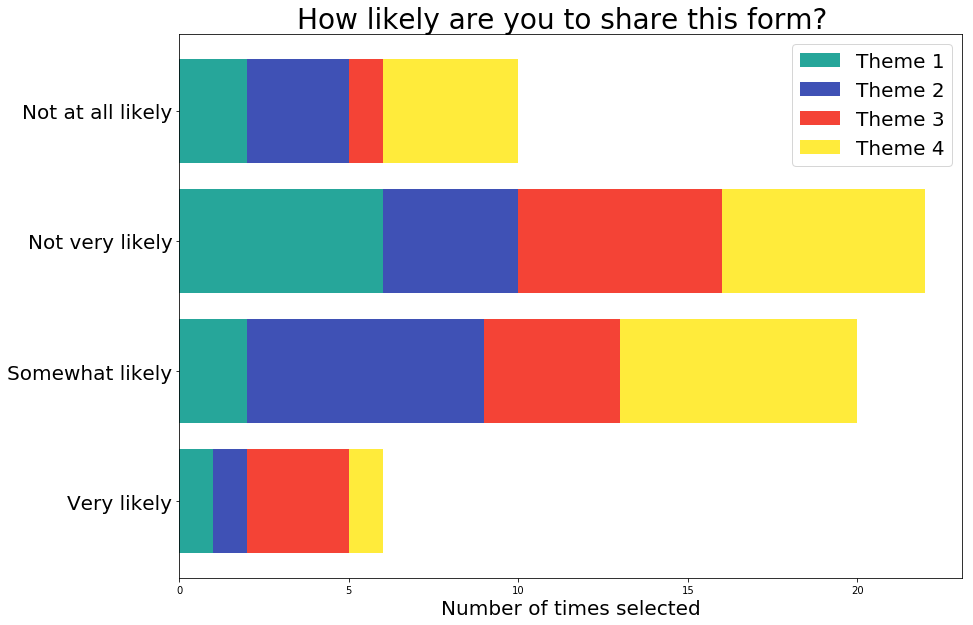

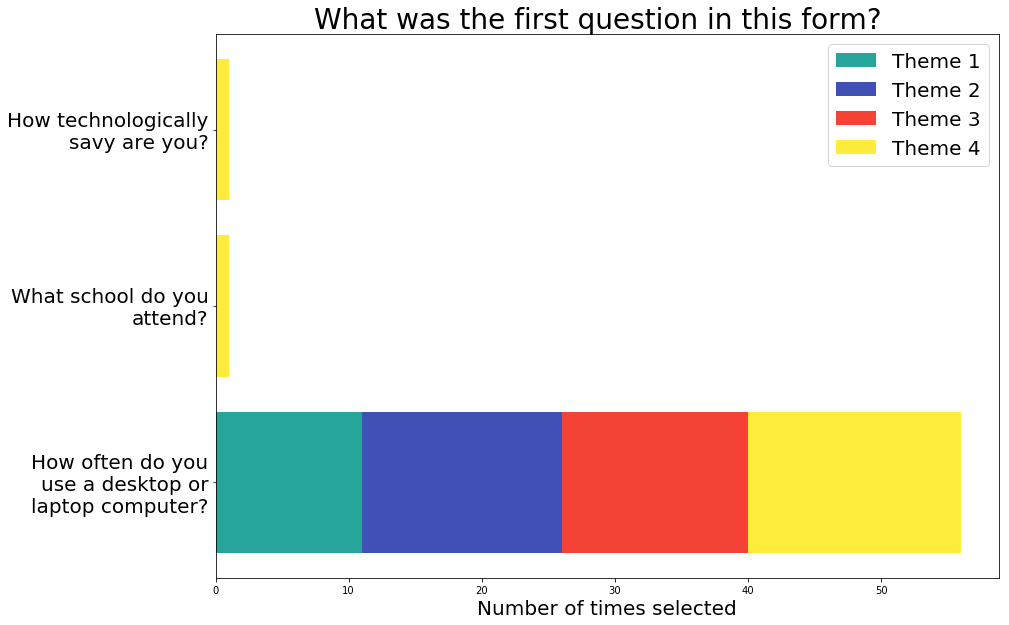

In [47]:
# the questions on the last page
last_page_questions = ['3_' + str(i) for i in range(1,8)]

counter = 0

for cur_question in last_page_questions:
    # filter the dataframe for just the question and the theme
    cur_question_df = df[[cur_question, 'themeChosen']].groupby(
        [cur_question, 'themeChosen']).size()
    
    
    # grab the columns of the grouped dataframe above
    num_people = list(cur_question_df.as_matrix())
    answer_choice = []
    color_scheme = []
    
    for i, j in cur_question_df.index:
        answer_choice.append(i)
        color_scheme.append(j)
        
    """
    order the data in a row of dictionaries such that:
        row = answer choice
        key = color scheme
        value = number of people w that color who made that choice
    """
    dataset = []
    for i in list(set(answer_choice)):
        cur_choice = {}
        j = 0
        while j < len(color_scheme):
            if answer_choice[j] == i:
                cur_choice[ color_scheme[j] ] = num_people[j]
            j += 1
        dataset.append(cur_choice)
    
    # add missing keys to the dataset rows
    for row in dataset:
        for key in list(set(color_scheme)):
            if key not in row:
                row[key] = 0
    
    
    # determine the order in which to show colors
    data_orders = [list(dataset[i].keys()) for i in range(len(dataset))]
    
    
    # calculate yticks based off options
    cur_question_index = int(cur_question.split("_")[1]) - 8
    title = list(survey_questions.keys())[cur_question_index] 
    choices = list(survey_questions.values())[cur_question_index]
    
    
    # filter out choices that weren't selected
    choices = [choices[c] for c in range(len(choices))
              if c+1 in list(set(answer_choice))]

    create_stacked_barchart(dataset, title, choices, colors, counter)
    
    counter += 1

In [29]:
df_time = df[["themeChosen", "timeToComplete"]].groupby("themeChosen").median()
df_time = df_time.rename(index=str, columns={"themeChosen": "Theme", "timeToComplete": "Time to Complete"})
df_time

,Time to Complete
themeChosen,
1,80.492
2,111.895
3,82.620
4,81.568


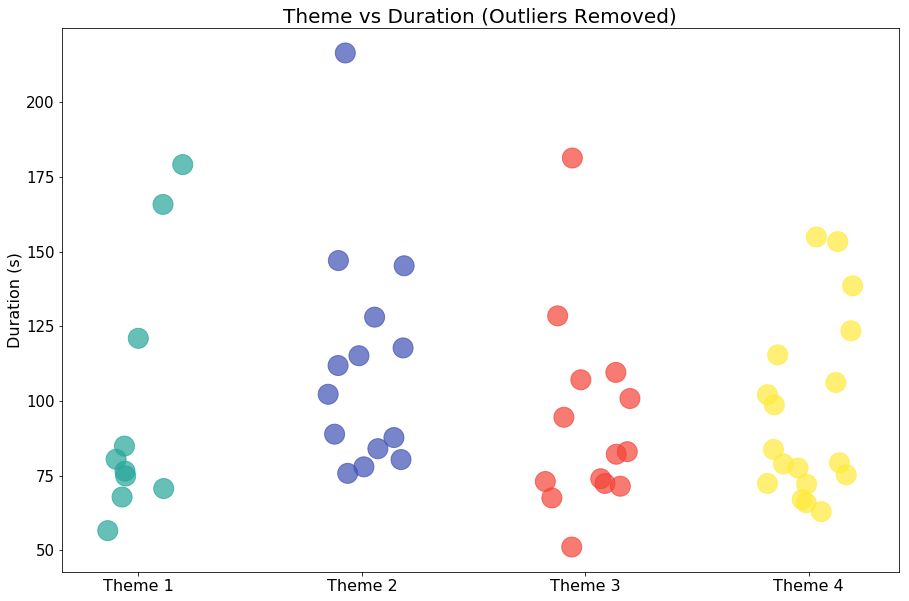

In [43]:
import random
import sys

df_times = df[np.abs(df.timeToComplete-df.timeToComplete.mean())<=(3*df.timeToComplete.std())]

themes = pd.cut(df_times.themeChosen, bins=[-1, 1.9, 2.9, 3.9, sys.maxsize],labels=False)
labels = np.array(['Theme 1', 'Theme 2', 'Theme 3', 'Theme 4'])
themes_labels = labels[themes]
theme_codes = {1:"#26a69a",2:"#3f51b5",3:"#f44336",4:"#ffeb3b"}
colors = [theme_codes[t] for t in df_times.themeChosen]
plt.figure(figsize=(15,10))
plt.title("Theme vs Duration (Outliers Removed)", fontsize=20)
plt.ylabel('Duration (s)', fontsize=16)
plt.xticks([0,1,2,3], labels, fontsize=16)
plt.yticks(fontsize=15)
plt.scatter([t + random.uniform(-0.2, 0.2) for t in themes], df_times.timeToComplete, c=colors, alpha=0.7, s=400)
plt.savefig('./Images/theme_v_duration.png', bbox_inches = 'tight');
plt.show()


### How many times was the computer button clicked?

In [31]:
df_clicked = df[["themeChosen", "computerButtonClicked"]]
df_clicked = df_clicked[df.computerButtonClicked != 0]
df_clicked

,themeChosen,computerButtonClicked
6,2,1
24,4,2
